In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
#Fonction pour charger la table data.csv
def load_dataset():
    csv_path  = os.path.join('data.csv')
    return pd.read_csv(csv_path)

In [3]:
#Chargement de la table data.csv
data = load_dataset()

In [4]:
#Affichage des 5 premieres lignes de la database
data.head(5)

,annotation_data,design_name,project_name,id,sequence,structure,signal_to_noise,eteRNA_score,min_SHAPE,max_SHAPE,threshold_SHAPE
0,1,Slalom Take 2,Thicker Zigzag,769718-1,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGCUCGCAGGAGUACGAA...,.............................((((.((((.((((......,1.437,86.7,0.055,0.606,0.330
1,2,d+m plots weaker again,Thicker Zigzag,769337-1,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUGCAUCAUACGAUAAA...,.............................((((.((((.((((......,3.227,68.0,-0.005,0.815,0.405
2,3,d+m plots weaker,Thicker Zigzag,769330-1,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUGCAUGCUACGACAAA...,.............................((((.((((.((((......,2.590,70.7,0.042,0.806,0.424
3,4,d+m plots,Thicker Zigzag,769323-1,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUCCAGGCGACCACAAA...,.............................((((.((((.((((......,1.012,73.3,0.000,0.685,0.343
4,5,Fiskers thick zigzag 3,Thicker Zigzag,767147-1,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUUGACCCGACAUGGAA...,.............................((((.((((.((((......,2.130,89.3,0.030,0.655,0.343


In [5]:
#Preprocessing pour nettoyage des caracteristiques inutiles 
def data_preprocessing(data):
    data = data.drop("design_name", axis=1)
    data = data.drop("project_name", axis=1)
    data = data.drop("id", axis=1)
    return data

In [6]:
#Application des preprocessing sur la table data
data = data_preprocessing(data)
data

,annotation_data,sequence,structure,signal_to_noise,eteRNA_score,min_SHAPE,max_SHAPE,threshold_SHAPE
0,1,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGCUCGCAGGAGUACGAA...,.............................((((.((((.((((......,1.437,86.7,0.055,0.606,0.330
1,2,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUGCAUCAUACGAUAAA...,.............................((((.((((.((((......,3.227,68.0,-0.005,0.815,0.405
2,3,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUGCAUGCUACGACAAA...,.............................((((.((((.((((......,2.590,70.7,0.042,0.806,0.424
3,4,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUCCAGGCGACCACAAA...,.............................((((.((((.((((......,1.012,73.3,0.000,0.685,0.343
4,5,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUUGACCCGACAUGGAA...,.............................((((.((((.((((......,2.130,89.3,0.030,0.655,0.343
...,...,...,...,...,...,...,...,...
2053,2054,GGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAU...,.............................................(...,0.840,78.7,-0.044,0.396,0.176
2054,2055,GGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAU...,.............................................(...,0.753,78.7,-0.049,0.441,0.196
2055,2056,GGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUA...,............................................((...,0.168,72.0,-0.034,0.302,0.134
2056,2057,GGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUA...,............................................((...,0.152,65.3,-0.035,0.315,0.140


In [7]:
#Sachant qu'on ne peut predire une valeur non numerique , j'ai extrait les caracteristique depuis notre structure d'ARN

def extract_dot_bracket_features(dot_bracket_structure):
    """
    Extract features from a dot bracket structure.

    Parameters:
    - dot_bracket_structure (str): Dot bracket representation of the RNA secondary structure.

    Returns:
    - dict: Dictionary containing extracted features.
    """
    features = {}

    # Longueur de la structure
    features['length'] = len(dot_bracket_structure)

    # Nombre total de paires de bases
    features['total_base_pairs'] = dot_bracket_structure.count('(')

    # Nombre de boucles
    features['total_loops'] = dot_bracket_structure.count('.')

    # Nombre de tiges
    features['total_stems'] = dot_bracket_structure.count('(')

    # Nombre de boucles internes
    features['internal_loops'] = dot_bracket_structure.count(')(')

    # Nombre de boucles externes
    features['external_loops'] = dot_bracket_structure.count('.')

    # Nombre de boucles non appariées
    features['unpaired_loops'] = dot_bracket_structure.count('.')

    # Longueur maximale des boucles
    max_loop_length = 0
    current_loop_length = 0
    for char in dot_bracket_structure:
        if char == '.':
            current_loop_length += 1
        else:
            if current_loop_length > max_loop_length:
                max_loop_length = current_loop_length
            current_loop_length = 0
    features['max_loop_length'] = max_loop_length

    # Nombre de branches
    features['total_branches'] = dot_bracket_structure.count('((')

    return features


In [8]:
# Appliquer la fonction extract_dot_bracket_features à chaque élément de la colonne "structure" du DataFrame
extracted_features = data["structure"].apply(extract_dot_bracket_features)

# Convertir les caractéristiques extraites en DataFrame
features_df = pd.DataFrame(extracted_features.tolist())

# Ajouter les colonnes de caractéristiques extraites au DataFrame d'origine
data_with_features = pd.concat([data, features_df], axis=1)


In [9]:
#Affichage du nouveau tableau contenant l'ensemble des caracteristique
data_with_features

,annotation_data,sequence,structure,signal_to_noise,eteRNA_score,min_SHAPE,max_SHAPE,threshold_SHAPE,length,total_base_pairs,total_loops,total_stems,internal_loops,external_loops,unpaired_loops,max_loop_length,total_branches
0,1,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGCUCGCAGGAGUACGAA...,.............................((((.((((.((((......,1.437,86.7,0.055,0.606,0.330,107,19,69,19,0,69,69,29,9
1,2,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUGCAUCAUACGAUAAA...,.............................((((.((((.((((......,3.227,68.0,-0.005,0.815,0.405,107,19,69,19,0,69,69,29,9
2,3,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUGCAUGCUACGACAAA...,.............................((((.((((.((((......,2.590,70.7,0.042,0.806,0.424,107,19,69,19,0,69,69,29,9
3,4,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUCCAGGCGACCACAAA...,.............................((((.((((.((((......,1.012,73.3,0.000,0.685,0.343,107,19,69,19,0,69,69,29,9
4,5,GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUUGACCCGACAUGGAA...,.............................((((.((((.((((......,2.130,89.3,0.030,0.655,0.343,107,19,69,19,0,69,69,29,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,2054,GGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAU...,.............................................(...,0.840,78.7,-0.044,0.396,0.176,107,15,77,15,0,77,77,45,7
2054,2055,GGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAU...,.............................................(...,0.753,78.7,-0.049,0.441,0.196,107,15,77,15,0,77,77,45,6
2055,2056,GGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUA...,............................................((...,0.168,72.0,-0.034,0.302,0.134,107,16,75,16,0,75,75,44,7
2056,2057,GGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUA...,............................................((...,0.152,65.3,-0.035,0.315,0.140,107,16,75,16,0,75,75,44,7


In [10]:
#Separation des targets et des caracteristique. Data_label est notre target vue qu'elle est composé uniquement des caracteristiques de notre structure
data_attribute = ["signal_to_noise", "eteRNA_score", "min_SHAPE", "max_SHAPE", "threshold_SHAPE"]
data_label = ["length", "total_base_pairs", "total_loops", "total_stems", "internal_loops", "external_loops", "unpaired_loops", "max_loop_length", "total_branches"]

In [29]:
#separation des données en donnée d'entrainement et en donnée de test 
X_train, X_test, y_train, y_test = train_test_split(data_with_features[data_attribute], data_with_features[data_label], test_size=0.2, random_state=100)
X_train

In [12]:
class PositiveTransformer(TransformerMixin):
    """
    Transformer personnalisé pour convertir les valeurs négatives en valeurs positives.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return abs(X)

In [13]:
#Petite pipeline pour correction des données qui vont echappé comme les données NA , les valeurs nulles et autres
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
    ("positive_transformer", PositiveTransformer())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, data_attribute),
])

cat_pipeline = ColumnTransformer([
    ("cat", num_pipeline, data_label),
])

prepared_data = full_pipeline.fit_transform(X_train)

In [14]:
#Entrainement du modele de regression lineaire 
lin_reg = LinearRegression(fit_intercept=True,  positive = True)

lin_reg.fit(prepared_data, y_train)

LinearRegression(positive=True)

In [15]:
#prediction de la structure de l'ARN
arn_train = lin_reg.predict(prepared_data)
arn_train

array([[106.9352669 ,  21.40994776,  62.19854788, ...,  62.19854788,
         18.27389543,   9.52792927],
       [106.94829778,  20.37984918,  64.21978572, ...,  64.21978572,
         20.54159195,   8.99275457],
       [106.95655445,  20.7076379 ,  65.50048746, ...,  65.50048746,
         21.97845546,   9.16269923],
       ...,
       [106.94737224,  20.43176001,  64.07622313, ...,  64.07622313,
         20.38052413,   9.02235061],
       [106.92138371,  20.6453493 ,  60.04510902, ...,  60.04510902,
         15.85787802,   9.1271865 ],
       [106.94729899,  21.15216931,  64.06486155, ...,  64.06486155,
         20.36777719,   9.38096149]])

In [16]:
#Calcule de l'erreur effectué par notre modele d'entrainement
lin_rse = mean_squared_error(arn_train, y_train)
lin_rse = np.sqrt(lin_rse)
lin_rse

6.407547307653624

In [17]:
arn_prediction = lin_reg.predict(X_test)
arn_prediction[0]

c:\Users\linen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([1.06918644e+02, 1.03362447e+02, 5.96201020e+01, 1.03362447e+02,
       7.00233908e-02, 5.96201020e+01, 5.96201020e+01, 1.53810480e+01,
       5.08719216e+01])

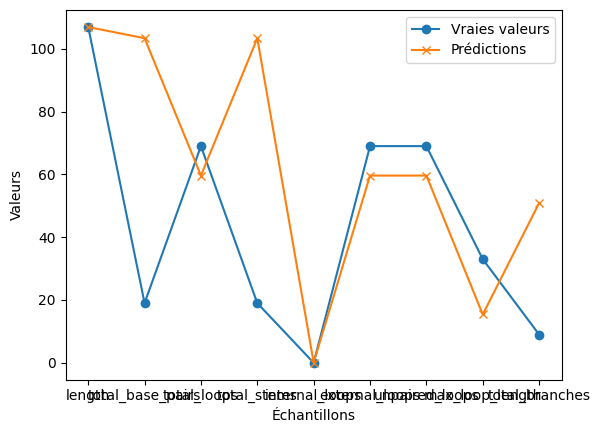

In [18]:
plt.plot(y_test.iloc[0], label='Vraies valeurs', marker='o')
plt.plot(arn_prediction[0], label='Prédictions', marker="x")

# Ajoutez des étiquettes et une légende
plt.xlabel('Échantillons')
plt.ylabel('Valeurs')
plt.legend()

# Affichez le graphique
plt.show()

In [19]:
#Calcule de l'erreur effectué par notre modele d'entrainement
lin_rse = mean_squared_error(arn_prediction, y_test)
lin_rse = np.sqrt(lin_rse)
lin_rse

44.566147572578934

In [31]:
scores = cross_val_score(lin_reg, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.16 accuracy with a standard deviation of 0.02


In [21]:
#Entrainement du modele en utilisant l'arbre de decision
tree_reg = DecisionTreeRegressor(random_state=0, splitter="random", criterion="poisson")
tree_reg.fit(prepared_data, y_train)

DecisionTreeRegressor(criterion='poisson', random_state=0, splitter='random')

In [22]:
tree_train = tree_reg.predict(prepared_data)
tree_train

array([[107.        ,  23.28571429,  60.42857143, ...,  60.42857143,
         14.21428571,  10.42857143],
       [107.        ,  18.97115385,  69.05769231, ...,  69.05769231,
         30.25961538,   8.16346154],
       [107.        ,  22.375     ,  62.25      , ...,  62.25      ,
         14.16666667,   9.83333333],
       ...,
       [107.        ,  20.03571429,  66.92857143, ...,  66.92857143,
         24.71428571,   8.64285714],
       [107.        ,  23.5503876 ,  59.89922481, ...,  59.89922481,
         17.72868217,  10.73643411],
       [107.        ,  24.        ,  59.        , ...,  59.        ,
         14.64      ,  11.        ]])

In [23]:
#Calcule de l'erreur effectué par notre modele d'entrainement
tree_rse = mean_squared_error(tree_train, y_train)
tree_rse = np.sqrt(tree_rse)
tree_rse

5.1881750887780935

In [24]:
#Prediction a partir de l'arbre de decision
tree_prediction = tree_reg.predict(X_test)
tree_prediction

c:\Users\linen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


array([[1.06528926e+02, 2.36033058e+01, 5.93223140e+01, 2.36033058e+01,
        1.65289256e-02, 5.93223140e+01, 5.93223140e+01, 1.74132231e+01,
        1.05454545e+01],
       [1.06528926e+02, 2.36033058e+01, 5.93223140e+01, 2.36033058e+01,
        1.65289256e-02, 5.93223140e+01, 5.93223140e+01, 1.74132231e+01,
        1.05454545e+01],
       [1.06528926e+02, 2.36033058e+01, 5.93223140e+01, 2.36033058e+01,
        1.65289256e-02, 5.93223140e+01, 5.93223140e+01, 1.74132231e+01,
        1.05454545e+01],
       [1.06528926e+02, 2.36033058e+01, 5.93223140e+01, 2.36033058e+01,
        1.65289256e-02, 5.93223140e+01, 5.93223140e+01, 1.74132231e+01,
        1.05454545e+01],
       [1.06528926e+02, 2.36033058e+01, 5.93223140e+01, 2.36033058e+01,
        1.65289256e-02, 5.93223140e+01, 5.93223140e+01, 1.74132231e+01,
        1.05454545e+01],
       [1.06528926e+02, 2.36033058e+01, 5.93223140e+01, 2.36033058e+01,
        1.65289256e-02, 5.93223140e+01, 5.93223140e+01, 1.74132231e+01,
        1.0

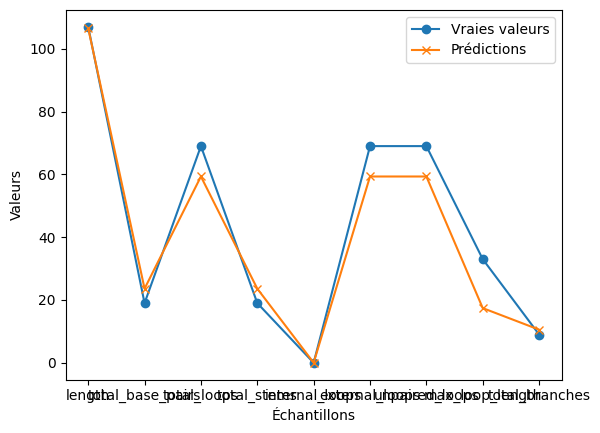

In [25]:
plt.plot(y_test.iloc[0], label='Vraies valeurs', marker='o')
plt.plot(tree_prediction[0], label='Prédictions', marker="x")

# Ajoutez des étiquettes et une légende
plt.xlabel('Échantillons')
plt.ylabel('Valeurs')
plt.legend()

# Affichez le graphique
plt.show()

In [26]:
#Calcule de l'erreur effectué par notre modele d'entrainement
tree_rse = mean_squared_error(y_test, tree_prediction)
tree_rse = np.sqrt(tree_rse)
tree_rse

8.660888756652808

In [30]:
scores = cross_val_score(tree_reg, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.32 accuracy with a standard deviation of 0.08
